In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import Normal
import os
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.pyplot as plt

from TrackedTractorENV import TractorEnv
from TD3 import TD3
from TD3 import ReplayBuffer
from TD3 import Trainer
from TD3 import LoggerVisualizer

# Training

**1. The agent is trained using multiple random seeds to assess the overall performance of the algorithm.**

**2. The directory `./log` contains records of episode rewards, episode costs, final SOC, and neural network losses, which are tracked during training through TensorBoard.**

**3. After training is complete, the TensorBoard tracking data is exported to an Excel file located in the `./log2excel` directory for further visualization and analysis.**


In [2]:
seed_list = [0, 1, 2, 3, 4, 5, 6]
for i in range(len(seed_list)):
    print("----------------------------------------------------------")
    print(f"SEED: {seed_list[i]}")
    print("----------------------------------------------------------")
    seed = seed_list[i]
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = TractorEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    min_action = -max_action
    max_episode_steps = env.model.TotalStep

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    log_dir = f'./log/seed{seed}'
    os.makedirs(log_dir, exist_ok=True)
    output_excel = f'./log2excel/training_logs_seed{seed}.xlsx'
    frequency = 500
    summary_writer = SummaryWriter(log_dir)
    visualizer = LoggerVisualizer(log_dir, output_excel)

    kwargs = {
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action,
        "device": device,
        "batch_size": 120,
        "discount": 0.99,
        "tau": 0.005,
        "policy_noise": 0.15,
        "noise_clip": 0.3,
        "policy_freq": 2,
        "actor_lr": 5e-5,
        "critic_lr": 5e-5,
        "hidden_sizes": [500, 400, 300],
    }

    agent = TD3(**kwargs)
    replay_buffer = ReplayBuffer(state_dim, action_dim)

    max_train_steps = 1000
    total_steps = 0

    random_steps = 5
    expl_noise = 0.1

    trainer = Trainer(env, agent, replay_buffer, max_train_steps, random_steps, device, expl_noise, summary_writer,frequency,visualizer)
    trainer.train()

----------------------------------------------------------
SEED: 0
----------------------------------------------------------
Actor(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=300, bias=True)
  )
  (out): Linear(in_features=300, out_features=1, bias=True)
)
Critic(
  (q1_layers): ModuleList(
    (0): Linear(in_features=5, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=300, bias=True)
  )
  (q2_layers): ModuleList(
    (0): Linear(in_features=5, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=300, bias=True)
  )
  (q1_out): Linear(in_features=300, out_features=1, bias=True)
  (q2_out): Linear(in_features=300, out_features=1, bias=True)
)
episode: 0 | Init SoC: 0.77

# Episode reward, episode cost and final SoC

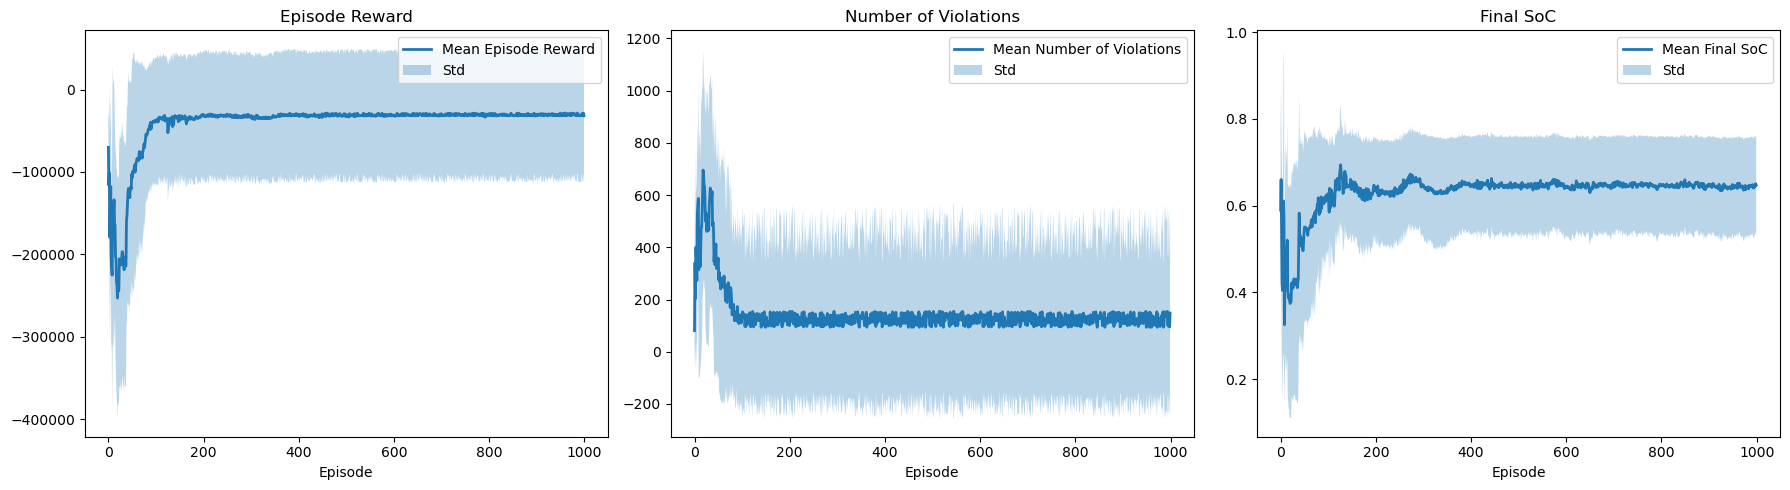

In [3]:
df_reward = pd.DataFrame()
df_cost = pd.DataFrame()
df_soc = pd.DataFrame()

for seed in seed_list:
    file_path = f'./log2excel/training_logs_seed{seed}.xlsx'
    train_log = pd.read_excel(file_path, sheet_name="Training_Data")
    df_reward[f'seed{seed}'] = train_log['Episode_Reward']
    df_cost[f'seed{seed}'] = train_log['Episode_Cost']
    df_soc[f'seed{seed}'] = train_log['SoC']

def plot_with_shading(df, metric_name, ax):
    episodes = df.index
    mean_val = df.mean(axis=1)
    std_val = df.std(axis=1)
    
    ax.plot(episodes, mean_val, label=f'Mean {metric_name}', linewidth=2)
    ax.fill_between(episodes, mean_val - std_val, mean_val + std_val, alpha=0.3, label='Std')
    ax.set_xlabel('Episode')
    ax.set_title(metric_name)
    ax.legend()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_with_shading(df_reward, 'Episode Reward', axs[0])
plot_with_shading(df_cost, 'Number of Violations', axs[1])
plot_with_shading(df_soc, 'Final SoC', axs[2])

plt.tight_layout()
plt.show()

**TD3 showed no signs of convergence under the Seed=5 configuration, and the specific details can be found in the record in TD3/Trainer.ipynb. This phenomenon indicates that the choice of random seed has a significant impact on the performance of TD3, with certain seeds potentially leading to poor training results, which may even require additional hyperparameter adjustments to ensure convergence. To avoid potential bias in comparison and ensure the fairness and representativeness of the analysis results, we have removed the data corresponding to Seed=5 from the data analysis phase.**

In [1]:
import numpy as np
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
seed_list = [0, 1, 2, 3, 4, 6]

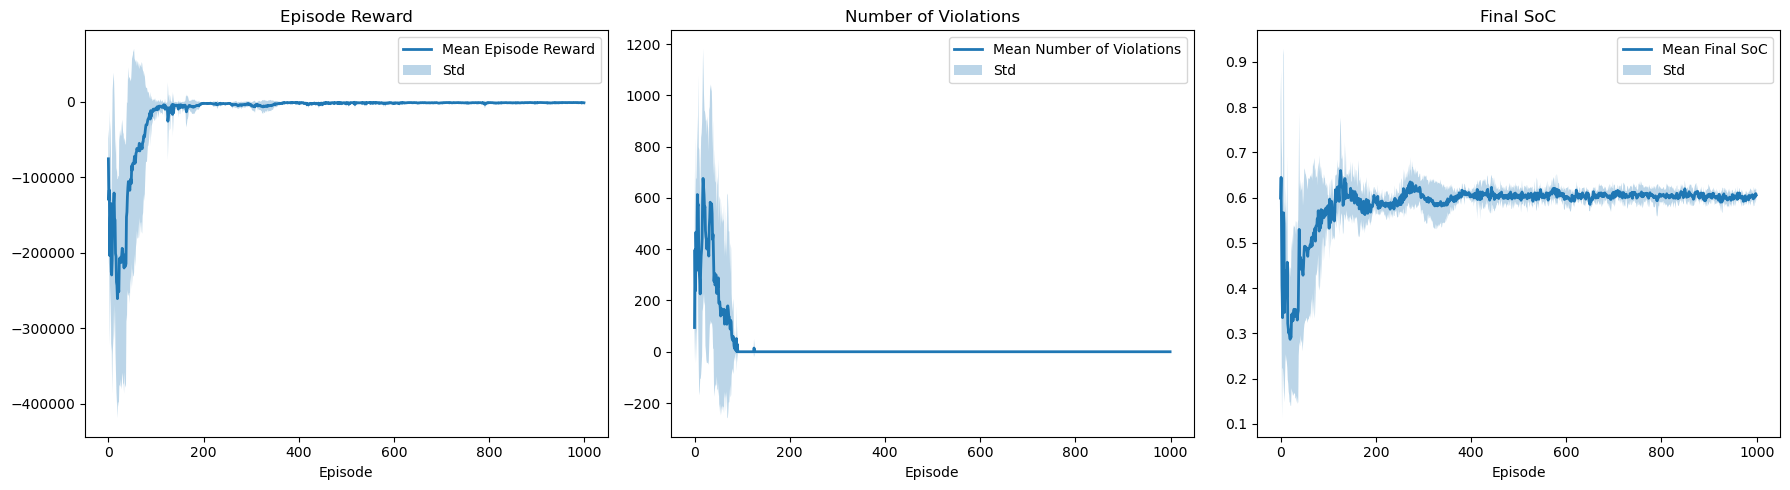

In [3]:
df_reward = pd.DataFrame()
df_cost = pd.DataFrame()
df_soc = pd.DataFrame()

for seed in seed_list:
    file_path = f'./log2excel/training_logs_seed{seed}.xlsx'
    train_log = pd.read_excel(file_path, sheet_name="Training_Data")
    df_reward[f'seed{seed}'] = train_log['Episode_Reward']
    df_cost[f'seed{seed}'] = train_log['Episode_Cost']
    df_soc[f'seed{seed}'] = train_log['SoC']

def plot_with_shading(df, metric_name, ax):
    episodes = df.index
    mean_val = df.mean(axis=1)
    std_val = df.std(axis=1)
    
    ax.plot(episodes, mean_val, label=f'Mean {metric_name}', linewidth=2)
    ax.fill_between(episodes, mean_val - std_val, mean_val + std_val, alpha=0.3, label='Std')
    ax.set_xlabel('Episode')
    ax.set_title(metric_name)
    ax.legend()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

plot_with_shading(df_reward, 'Episode Reward', axs[0])
plot_with_shading(df_cost, 'Number of Violations', axs[1])
plot_with_shading(df_soc, 'Final SoC', axs[2])

plt.tight_layout()
plt.show()